# Sophisticated inference

This notebook demonstrates tree searching policies.

In [13]:
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr

key = jr.PRNGKey(0)

In [14]:
import networkx as nx
from pymdp.jax.envs import GraphEnv


def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }


graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
env = GraphEnv(graph, object_locations=[4], agent_locations=[0])

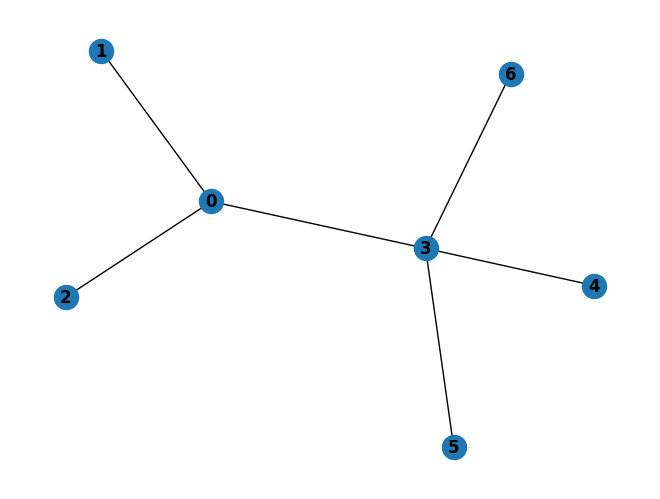

In [15]:
nx.draw(graph, with_labels=True, font_weight="bold")

Let's create an agent, we give the agent a prior on the object location to showcase the planning depth and pruning.

In [22]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]
D[0] = D[0].at[0, 0].set(100.0)
D[1] = D[1].at[0, 4].set(10.0)
D = jtu.tree_map(lambda x: x / x.sum(), D)

agent = Agent(A, B, C, D, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=1, apply_batch=False)

In [23]:
keys = jr.split(key, 2)
key = keys[0]
obs, env = env.step(keys[1:])

In [24]:
empirical_prior = agent.D

qs = agent.infer_states(
    observations=obs,
    past_actions=None,
    empirical_prior=empirical_prior,
    qs_hist=None,
)

In [26]:
from pymdp.jax.planning.si import tree_search

tree = tree_search(agent, qs, 4)

In [27]:
import matplotlib.pyplot as plt


def plot_plan_tree(
    tree,
    font_size=12,
):
    root_node = tree.root()
    print(root_node["n"])

    colormap = plt.cm.Blues
    colormap_policy = plt.cm.Reds

    # create graph
    count = 0
    G = nx.Graph()
    to_visit = [(root_node, 0)]
    labels = {}
    colors = []

    G.add_node(count)
    labels[0] = ""
    colors.append((0.0, 0.0, 0.0, 1.0))
    count += 1

    # visit children
    while len(to_visit) > 0:
        node, id = to_visit.pop()
        for child in node["children"]:
            G.add_node(count)
            G.add_edge(id, count)

            cm = colormap
            if "policy" in child.keys():
                labels[count] = child["policy"][0]
                cm = colormap_policy
            elif "observation" in child.keys():
                o = child["observation"]
                labels[count] = str(o[0][0]) + " " + str(o[1][0])
            else:
                labels[count] = ""

            r, g, b, a = cm(child.get("prob", 0))
            colors.append((r, g, b, a))

            to_visit.append((child, count))
            count += 1.0

    # from networkx.drawing.nx_pydot import graphviz_layout

    # pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        with_labels=True,
        font_size=font_size,
        labels=labels,
        node_color=colors,
    )

0


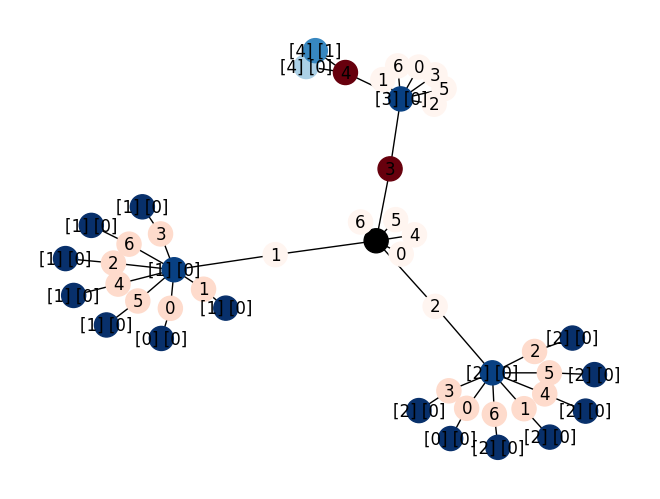

In [29]:
plot_plan_tree(tree)

In [31]:
from pymdp.jax.envs.rollout import rollout
from pymdp.jax.planning.si import si_policy_search

# TODO we cannot yet use this with rollout as it cannot be jit-ed
# last, result, env = rollout(agent, env, 10, key, policy_search=si_policy_search(max_depth=3))